In [1]:
!pip install tensorflow
!pip install datasets
!pip install transformers

In [2]:
!pip install tensorflow-addons

In [3]:
!pip install tensorflow_datasets
!pip install pydot

  Using cached protobuf-4.25.3-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
Using cached protobuf-4.25.3-cp37-abi3-macosx_10_9_universal2.whl (394 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 4.25.3 which is incompatible.


In [4]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import optimizers
from keras import layers
from keras import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, InputLayer
from os.path import isfile

print(tf.__version__)

2.15.0


In [5]:
import numpy as np
import tensorflow_datasets as tfds

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
def preprocess(image, label):
    image = tf.image.resize(image, [96, 96])
    # image = tf.image.rgb_to_grayscale(image)
    # image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label


In [8]:
def augment(image, label):
    image = tf.image.resize(image, [96, 96])
    # image = tf.image.rgb_to_grayscale(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1) # Adjust brightness by up to 10%
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1) # Adjust contrast between 90% and 110%
    # image = tf.cast(image, tf.float32) / 255.0
    return image, label


(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'malaria',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.repeat(2)
ds_validation = ds_validation.repeat(2)

train_ds = ds_train.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = ds_validation.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)

In [9]:
img_width = 96
img_height = 96

img_size = (img_width, img_height)

In [10]:
print(type(train_ds))

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512,]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [11]:
pretrained_model_no = 1

In [12]:
model = make_model(input_shape=img_size + (3,), num_classes=2)
model.summary()
# keras.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 128)          3584      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                               

In [13]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("model_4_epoch_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
1206/1206 [==============================] - 797s 660ms/step - loss: 0.1661 - accuracy: 0.9428 - val_loss: 0.3639 - val_accuracy: 0.8674
Epoch 2/10
1206/1206 [==============================] - 858s 711ms/step - loss: 0.1334 - accuracy: 0.9566 - val_loss: 0.1925 - val_accuracy: 0.9367
Epoch 3/10
1206/1206 [==============================] - 1092s 905ms/step - loss: 0.1248 - accuracy: 0.9583 - val_loss: 0.1666 - val_accuracy: 0.9353
Epoch 4/10
1206/1206 [==============================] - 1107s 918ms/step - loss: 0.1182 - accuracy: 0.9609 - val_loss: 0.2048 - val_accuracy: 0.9368
Epoch 5/10
1206/1206 [==============================] - 774s 641ms/step - loss: 0.1133 - accuracy: 0.9624 - val_loss: 0.1140 - val_accuracy: 0.9590
Epoch 6/10
1206/1206 [==============================] - 778s 645ms/step - loss: 0.1094 - accuracy: 0.9630 - val_loss: 0.1276 - val_accuracy: 0.9569
Epoch 7/10
1206/1206 [==============================] - 773s 641ms/step - loss: 0.1063 - accuracy: 0.9635 - va

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%, Test Loss: {test_loss:.4f} \n")

best_model_no = ...
best_model_accuracy = ...

for i in range(1,11):
    model_name_path = "./model_4_epoch_{0}.keras".format(i)
    current_model = keras.models.load_model(model_name_path)
    print("\n-------------------------Model {0}---------------------------------".format(i))
    test_loss, test_accuracy = current_model.evaluate(test_ds)
    print("Test Accuracy: {0:.2f}%, Test Loss: {1:.4f}".format(test_accuracy * 100, test_loss))
    if i == 1:
        best_model_no = i
        best_model_accuracy = test_accuracy
    else:
        if test_accuracy > best_model_accuracy:
            best_model_no = i
            best_model_accuracy = test_accuracy

print("Best Model: Model {0}".format(best_model_no))

130/130 [==============================] - 18s 139ms/step - loss: 0.1845 - accuracy: 0.9526
Test Accuracy: 95.26%, Test Loss: 0.1845 




-------------------------Model 1---------------------------------
130/130 [==============================] - 19s 145ms/step - loss: 0.3847 - accuracy: 0.8667
Test Accuracy: 86.67%, Test Loss: 0.3847



-------------------------Model 2---------------------------------
130/130 [==============================] - 18s 140ms/step - loss: 0.2080 - accuracy: 0.9357
Test Accuracy: 93.57%, Test Loss: 0.2080



-------------------------Model 3---------------------------------
130/130 [==============================] - 18s 139ms/step - loss: 0.1784 - accuracy: 0.9337
Test Accuracy: 93.37%, Test Loss: 0.1784



-------------------------Model 4---------------------------------
130/130 [==============================] - 18s 138ms/step - loss: 0.2180 - accuracy: 0.9342
Test Accuracy: 93.42%, Test Loss: 0.2180



-------------------------Model 5---------------------------------
130/130 [==============================] - 18s 139ms/step - loss: 0.1283 - accuracy: 0.9574
Test Accuracy: 95.74%, Test Loss: 0.1283



-------------------------Model 6---------------------------------
130/130 [==============================] - 18s 139ms/step - loss: 0.1480 - accuracy: 0.9545
Test Accuracy: 95.45%, Test Loss: 0.1480



-------------------------Model 7---------------------------------
130/130 [==============================] - 18s 139ms/step - loss: 0.1374 - accuracy: 0.9540


Test Accuracy: 95.40%, Test Loss: 0.1374

-------------------------Model 8---------------------------------
130/130 [==============================] - 18s 138ms/step - loss: 0.1313 - accuracy: 0.9584
Test Accuracy: 95.84%, Test Loss: 0.1313



-------------------------Model 9---------------------------------
130/130 [==============================] - 18s 138ms/step - loss: nan - accuracy: 0.9448
Test Accuracy: 94.48%, Test Loss: nan



-------------------------Model 10---------------------------------
130/130 [==============================] - 18s 139ms/step - loss: 0.1845 - accuracy: 0.9526
Test Accuracy: 95.26%, Test Loss: 0.1845
Best Model: Model 8


130/130 [==============================] - 18s 139ms/step


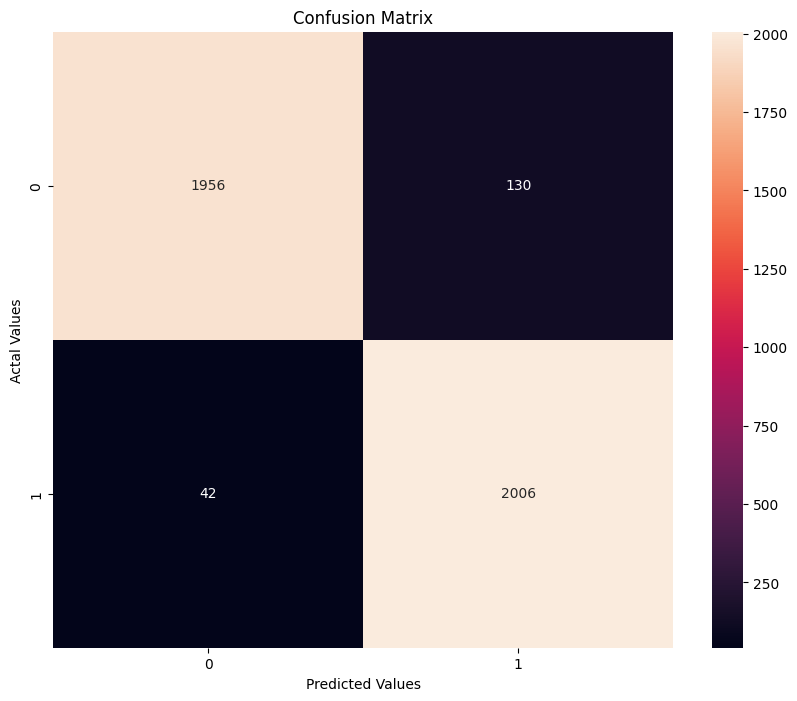

In [15]:
best_model_path = "./model_4_epoch_{0}.keras".format(best_model_no)
best_model = keras.models.load_model(best_model_path)

def returnLabel(pred):
    if pred > 0.5:
        return 1
    return 0

y_pred = best_model.predict(test_ds)
retrieve = np.vectorize(returnLabel)
y_pred_binary = retrieve(y_pred)
y_test = np.concatenate([y for x, y in test_ds], axis=0)

cnf_mat = confusion_matrix(y_test, y_pred_binary)

#Code to print confusion matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cnf_mat, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [16]:
def plot_learningCurve(history, epoch):
  epoch_range= range(1, epoch+1)
  #plot training and validation accuracy values
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

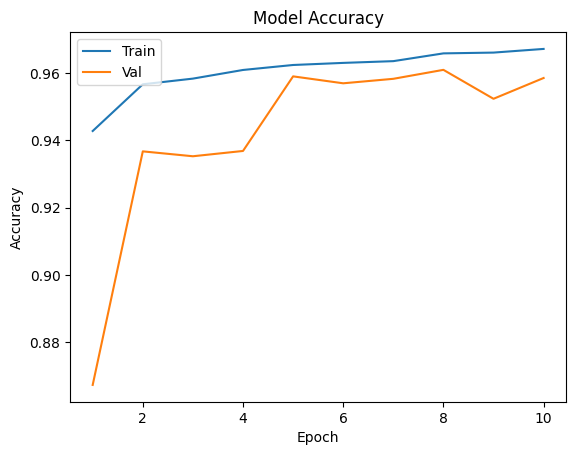

In [17]:
plot_learningCurve(history, 10)